# Working with DESI spectroperfectionism resolution matrix data

This notebook provides some brief examples of working with the RESOLUTION HDUs of DESI coadd, spectra, and frame files.

The first half of this notebook requires numpy, scipy, matplotlib, and fitsio. The second half requires a DESI kernel to get desispec.

Stephen Bailey<br>
December 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from desispec.io import read_spectra
import fitsio

from scipy.sparse import dia_matrix

## DESI coadd / spectra files

DESI spectra and coadd files have Header Data Units (HDUs) like
`B_RESOLUTION`, `R_RESOLUTION`, and `Z_RESOLUTION` containing
N *diagonals* of the resolution matrix for 500 spectra for each
of the cameras B, R, Z.

The corresponding wavelengths, fluxes, and inverse variances
(1/error^2) are in `[BRZ]_WAVELENGTH` and `[BRZ]_FLUX`, and `[BRZ]_IVAR`

In [2]:
coaddfile = '/global/cfs/cdirs/desi/spectro/redux/everest/tiles/cumulative/1900/20210614/coadd-0-1900-thru20210614.fits'
fx = fitsio.FITS(coaddfile)
print(fx)


  file: /global/cfs/cdirs/desi/spectro/redux/everest/tiles/cumulative/1900/20210614/coadd-0-1900-thru20210614.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      BINARY_TBL      EXP_FIBERMAP
  3      IMAGE_HDU       B_WAVELENGTH
  4      IMAGE_HDU       B_FLUX
  5      IMAGE_HDU       B_IVAR
  6      IMAGE_HDU       B_MASK
  7      IMAGE_HDU       B_RESOLUTION
  8      IMAGE_HDU       R_WAVELENGTH
  9      IMAGE_HDU       R_FLUX
  10     IMAGE_HDU       R_IVAR
  11     IMAGE_HDU       R_MASK
  12     IMAGE_HDU       R_RESOLUTION
  13     IMAGE_HDU       Z_WAVELENGTH
  14     IMAGE_HDU       Z_FLUX
  15     IMAGE_HDU       Z_IVAR
  16     IMAGE_HDU       Z_MASK
  17     IMAGE_HDU       Z_RESOLUTION
  18     BINARY_TBL      SCORES


Let's inspect the resolution matrix for the Z camera

In [3]:
wave = fitsio.read(coaddfile, 'Z_WAVELENGTH')
flux = fitsio.read(coaddfile, 'Z_FLUX')
rdiags = fitsio.read(coaddfile, 'Z_RESOLUTION')
nspec, ndiag, nwave = rdiags.shape

print(f'wave.shape = {wave.shape}')
print(f'flux.shape = (nspec, nwave) = {flux.shape}')
print(f'rdiags.shape = (nspec, ndiags, nwave) = {rdiags.shape}')

wave.shape = (2881,)
flux.shape = (nspec, nwave) = (500, 2881)
rdiags.shape = (nspec, ndiags, nwave) = (500, 11, 2881)


There are 500 spectra, with 2881 wavelengths each, and we kept 11 diagonals of the resolution matrix,
corresponding to offsets from the main diagonal [5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5].

`rdiags[i]` are the diagonal elements of the resolution matrix for spectrum `i`.
Let's look at the first 50 wavelenths:

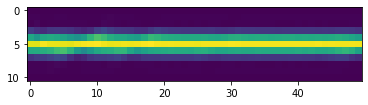

In [4]:
plt.imshow(rdiags[0][:, 0:50])

But how do we actually turn that into a matrix that we can multiply (convolve) with a model spectrum?
The diagonals are stored in a form designed to work well with scipy sparse matrices, where you give it the
diagonals, which offsets they correspond to, and the size of the final output sparse matrix:

In [5]:
offsets = np.arange(ndiag//2, -(ndiag//2)-1, -1)
R = dia_matrix((rdiags[0], offsets), shape=(nwave, nwave)) 

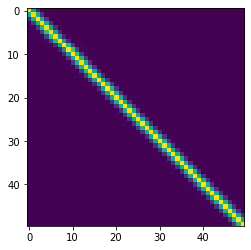

In [6]:
plt.imshow(R.todense()[0:50, 0:50], origin='upper')

To convolve a model spectrum with this resolution matrix, just multiply (which will do a matrix-vector dot product): 

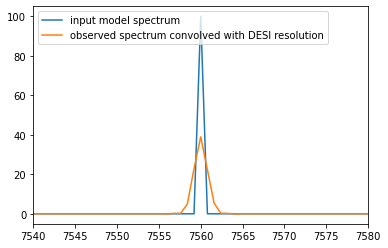

In [7]:
model = np.zeros(nwave)
model[50] = 100
plt.plot(wave, model, label='input model spectrum')
plt.plot(wave, R*model, label='observed spectrum convolved with DESI resolution')
plt.xlim(7540, 7580)
plt.legend(loc='upper left')

## Using desispec wrappers

The resolution format storing diagonals was designed to be usable with `scipy.sparse.dia_matrix`
without requiring DESI-specific code, but if you are willing to have `desispec` as a dependency
you can get some convenience wrappers:

In [8]:
from desispec.resolution import Resolution
R = Resolution(rdiags[0])

(7540.0, 7580.0)

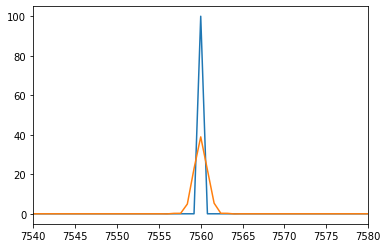

In [9]:
plt.plot(wave, model)
plt.plot(wave, R*model)
plt.xlim(7540, 7580)

Even more convenient is using the read_spectra I/O wrapper which reads all the HDUs
and creates the sparse R matrices for every spectrum.

See https://github.com/desihub/tutorials/blob/master/Dec2021/Everest_Tutorial_Dec2021.ipynb for more details

In [10]:
from desispec.io import read_spectra
coadd = read_spectra(coaddfile)

INFO:spectra.py:285:read_spectra: iotime 0.777 sec to read coadd-0-1900-thru20210614.fits at 2022-06-15T09:21:46.259976


(7540.0, 7580.0)

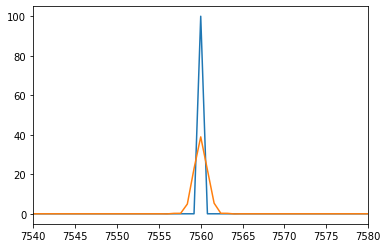

In [11]:
plt.plot(wave, model)
plt.plot(wave, coadd.R['z'][0]*model)
plt.xlim(7540, 7580)

## Futher reading

[DESI-6538](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=6538) is the companion presentation
about spectroperfectionism, which ends with this notebook.

See https://github.com/desihub/tutorials/blob/master/redrock/RedrockOutputs.ipynb for an example working
with redrock output to make a galaxy model and convolve it with the spectral resolution to compare to the data.